In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl

from ex_cosmology import p
from dset import get_dataloader, load_pretrained_model
from dset import get_validation

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform2d import DWT2d
from utils import get_2dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_2dfilts, plot_2dreconstruct, plot_wavefun

# evaluation
from eval_cosmology import load_results, rmse_bootstrap, extract_patches
from peak_counting import PeakCount, rmse

# TRIM module
sys.path.append('../../lib/trim')
from trim import TrimModel
from utils import tuple_to_tensor, tensor_to_tuple

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load results

In [2]:
dirs = [
        "db5_saliency_warmstart_seed=1_new"
        ]
dics, _, _ = load_results(dirs)

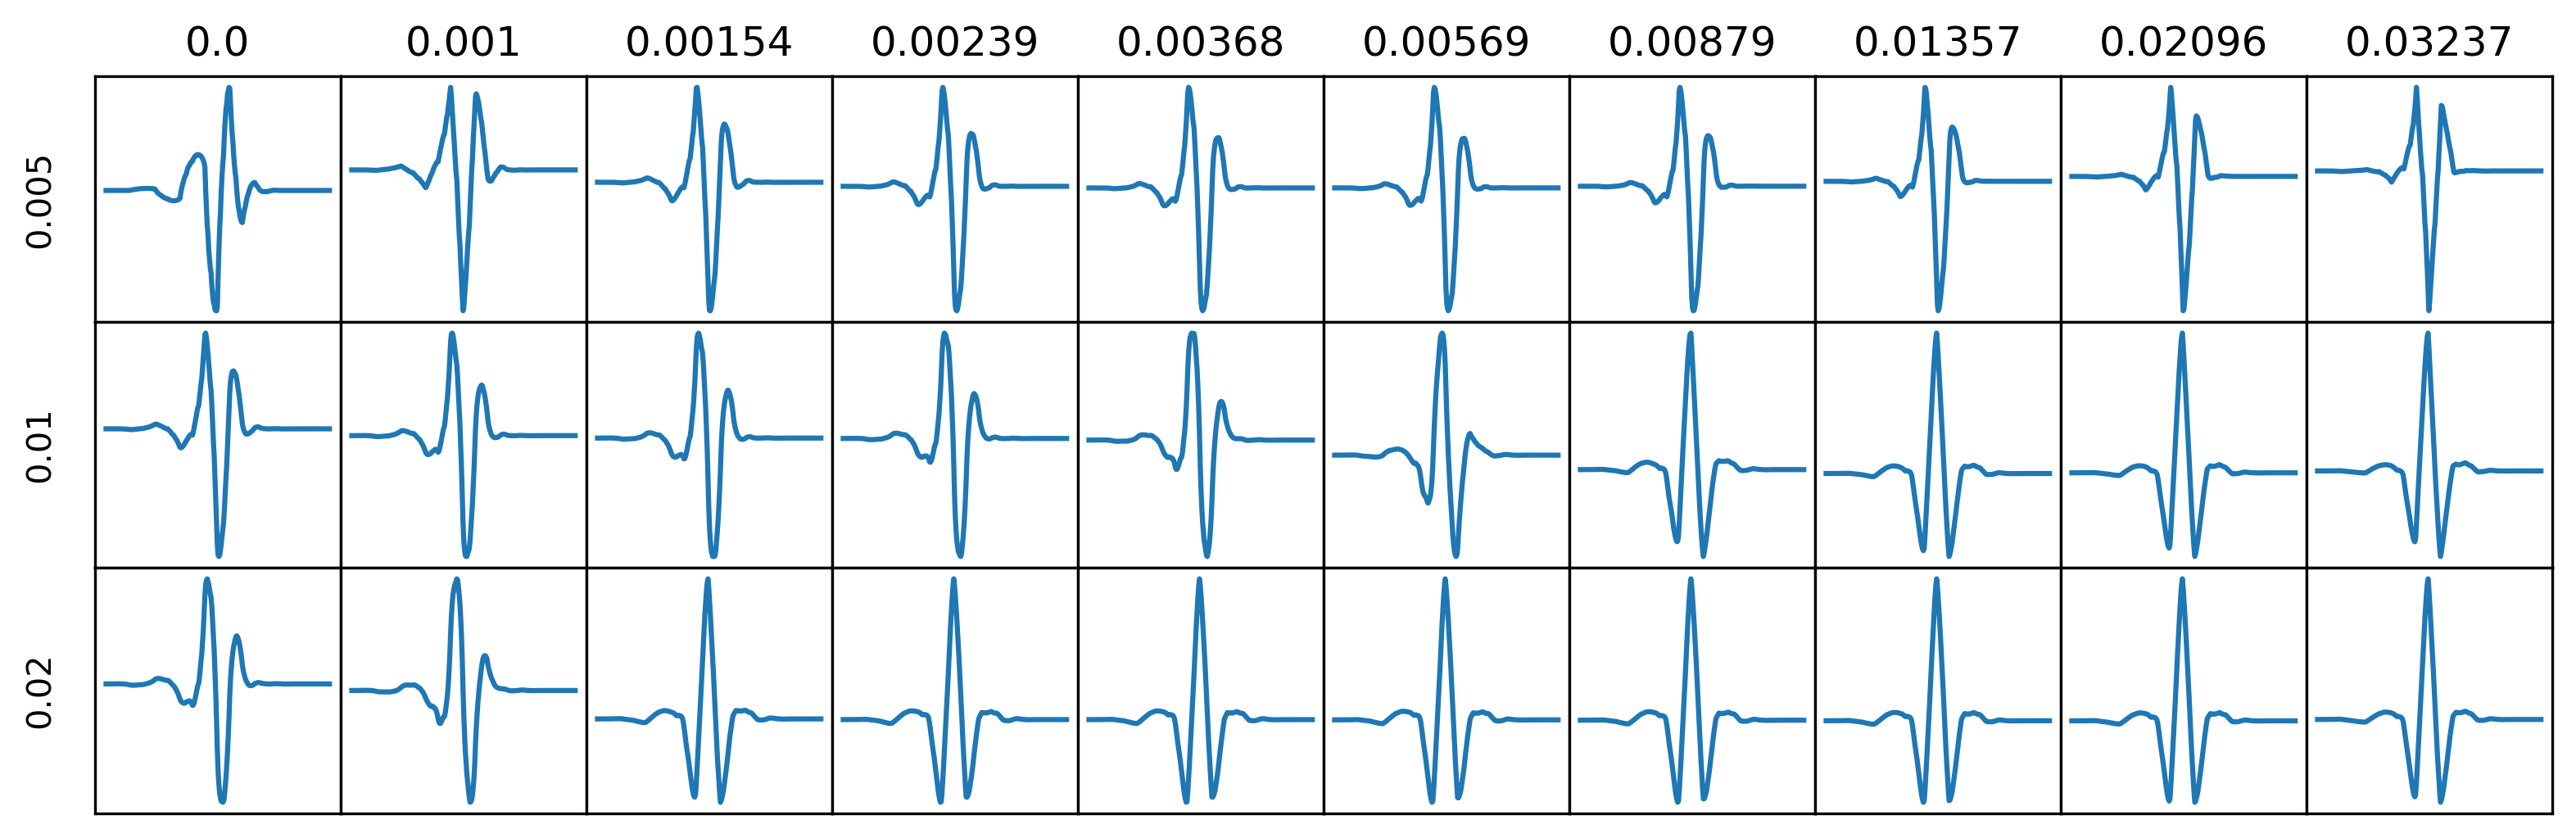

In [3]:
index = 0 # select which result to display
lamwaves = np.fromiter(dics[index]['lamL1wave'].values(), dtype=float)
lamattrs = np.fromiter(dics[index]['lamL1attr'].values(), dtype=float)
lamwaves = np.unique(lamwaves)
lamattrs = np.unique(lamattrs)
R = len(lamwaves)
C = len(lamattrs)

plt.figure(figsize=(C+1, R+1), dpi=300)
gs = gridspec.GridSpec(R, C,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(R+1), bottom=0.5/(R+1), 
         left=0.5/(C+1), right=1-0.5/(C+1))  

for r in range(R):
    for c in range(C):
        ax = plt.subplot(gs[r,c])
        ax.plot(dics[index]['x'][(r,c)], dics[index]['psi'][(r,c)]) 
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,
            left=False,
            right=False,
            labelbottom=False) 
        if c == 0:
            plt.ylabel(str(lamwaves[r]))
        if r == 0:
            plt.title(str(lamattrs[c]))

# plt.savefig('figures/cosmo_wave_vary.pdf', bbox_inches='tight')

In [6]:
# get dataloader and model
train_loader, val_loader = get_dataloader(p.data_path, 
                                          img_size=p.img_size[2],
                                          split_train_test=True,
                                          batch_size=p.batch_size) 

model = load_pretrained_model(model_name='resnet18', device=device, data_path=p.model_path)   

# validation dataset
test_loader = get_validation(p.data_path, 
                             img_size=p.img_size[2],
                             batch_size=p.batch_size)

# select optimal bin using heldout dataset

In [7]:
# DB5
wt_o = DWT2d(wave='db5', mode='zero', J=4, 
             init_factor=1, noise_factor=0, const_factor=0)

# extract kernels
kern_list = []
for wt in [wt_o] + list(dics[0]['wt'].values()):
    filt = get_2dfilts(wt)
    h = filt[0][0]
    g = filt[0][1]
    kern_list.append(extract_patches(h, g))
    
bds = np.linspace(0.015,0.035,5)
scores = np.zeros((len(bds), len(kern_list)))  

for i,b in enumerate(bds):
    for j,kernels in enumerate(kern_list):
        pcw = PeakCount(peak_counting_method='custom', 
                        bins=np.linspace(0,b,23),
                        kernels=kernels)
        pcw.fit(train_loader)
        y_preds, y_params = pcw.predict(val_loader)
        scores[i,j] = rmse(y_params, y_preds)
        pkl.dump(scores, open('results/scores_new.pkl', 'wb'))  
        print(
            "\riteration bd={}/{} kern={}/{}".format(
                i + 1, len(bds), j + 1, len(kern_list)
            ),
            end="",
        )        
        
print('\n', np.min(scores))

iteration bd=5/5 kern=31/31
 0.010689967833689003


# optimal filter

In [8]:
# load optimal wavelet for prediction on heldout dataset
# scores = pkl.load(open('results/scores_new.pkl', 'rb'))
row, col = np.unravel_index(np.argmin(scores, axis=None), scores.shape)
bd_opt = bds[row]
idx1, idx2 = list(dics[0]['wt'].keys())[col-1]
wt = dics[0]['wt'][(idx1, idx2)]   
lamL1wave = dics[0]['lamL1wave'][(idx1, idx2)]
lamL1attr = dics[0]['lamL1attr'][(idx1, idx2)]
print('lambda: {} gamma: {}'.format(lamL1wave, lamL1attr))

# AWD prediction performance
filt = get_2dfilts(wt)
h = filt[0][0]
g = filt[0][1]
kernels = extract_patches(h, g)
pcw = PeakCount(peak_counting_method='custom', 
                bins=np.linspace(0,bd_opt,23),
                kernels=kernels)
pcw.fit(train_loader)
y_preds, y_params = pcw.predict(test_loader)
acc, std = rmse_bootstrap(y_preds, y_params)
print("AWD: ", acc, std)

# original wavelet prediction performance
filt = get_2dfilts(wt_o)
h = filt[0][0]
g = filt[0][1]
kernels = extract_patches(h, g)
pcw = PeakCount(peak_counting_method='custom', 
                bins=np.linspace(0,bds[np.argmin(scores[:,0])],23),
                kernels=kernels)
pcw.fit(train_loader)
y_preds, y_params = pcw.predict(test_loader)
acc, std = rmse_bootstrap(y_preds, y_params)
print("DB5: ", acc, std)

lambda: 0.02 gamma: 0.00368
AWD:  0.01028726999170842 0.00033492254696672005
DB5:  0.015692681086327664 0.00048067312692403594


# compression

In [9]:
# define trim model
mt = TrimModel(model, wt.inverse, use_residuals=True)    
mt_o = TrimModel(model, wt_o.inverse, use_residuals=True)  
attributer = Attributer(mt, attr_methods='Saliency', device='cuda')
attributer_o = Attributer(mt_o, attr_methods='Saliency', device='cuda')

# compute compression rate and representations
attrs = {'AWD': torch.tensor([]),
         'DB5': torch.tensor([])}
reps = {'AWD': torch.tensor([]),
        'DB5': torch.tensor([])}
wt, wt_o = wt.to(device), wt_o.to(device)
for data, _ in test_loader:
    data = data.to(device)
    i = 0
    for w in [wt, wt_o]:
        if i == 0:
            data_t = w(data)
            with torch.backends.cudnn.flags(enabled=False):
                attributions = attributer(data_t, target=0, additional_forward_args=deepcopy(data))   
            y, _ = tuple_to_tensor(data_t)
            reps['AWD'] = torch.cat((reps['AWD'], y.detach().cpu()), dim=0)
            z, _ = tuple_to_tensor(attributions)
            attrs['AWD'] = torch.cat((attrs['AWD'], z.detach().cpu()), dim=0)
        else:
            data_t = w(data)
            with torch.backends.cudnn.flags(enabled=False):
                attributions = attributer_o(data_t, target=0, additional_forward_args=deepcopy(data))   
            y, _ = tuple_to_tensor(data_t)
            reps['DB5'] = torch.cat((reps['DB5'], y.detach().cpu()), dim=0)
            z, _ = tuple_to_tensor(attributions)
            attrs['DB5'] = torch.cat((attrs['DB5'], z.detach().cpu()), dim=0)
        i += 1
reps['AWD'] = reps['AWD'].reshape(-1)
reps['DB5'] = reps['DB5'].reshape(-1) 
attrs['AWD'] = attrs['AWD'].reshape(-1)
attrs['DB5'] = attrs['DB5'].reshape(-1) 

thresh1 = 1e-3
thresh2 = 1e-3
c_rate_AWD = 1.0*((abs(reps['AWD']) > thresh1) & (abs(attrs['AWD']) > thresh2)).sum() / reps['AWD'].shape[0]
c_rate_DB5 = 1.0*((abs(reps['DB5']) > thresh1) & (abs(attrs['DB5']) > thresh2)).sum() / reps['DB5'].shape[0]
print(c_rate_AWD.item(), c_rate_DB5.item())

0.6101066470146179 0.6201186180114746
